# IBM Applied Data Science Capstone

## The Battle of Neighborhoods: NYC Families
#### Author Eric Jones

This notebook is the primary workspace for my IBM Applied Data Science Capstone project titled 'The Battle of Neighborhoods: NYC Families'. In this project, I explore the neighborhoods within New York City to determine which neighborhoods are best suited for families with children living in the city. I use neighborhood data and the Foursquare API to cluster neighborhoods based on family and children-oriented venues. Using this analysis, I determine a list of neighborhoods that are best for families in New York City.

New York City is a primarily urban environment, but as a global hub for business, art, travel, and other things, many people move and live in the city. Many of these people are part of families that include children. For this reason, determining neighborhoods with nearby access to civic centers, childcare facilities, parks, and other similar venues can highlight the best neighborhoods for children in the city. 

## Import Necessary Libraries

In [51]:
# Import all necessary libraries
import pandas as pd
import numpy as np

!pip install geopy
from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

!pip install folium
import folium

import json

import requests
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

print('Libraries successfully imported!')

Libraries successfully imported!


## Import the New York City Neighborhood Dataset

In [2]:
# Access the dataset for New York neighborhoods
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
# Load the data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [7]:
# Extract the data in the features key
neighborhoods_data = newyork_data['features']

## Create the Neighborhood Dataframe

In [8]:
# Define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# Define the initial dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [9]:
# Loop through data to fill in the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [12]:
# Check the first few elements of the dataframe
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
# Check the size of the dataframe
print('The dataframe includes {} neighborhoods in New York City.'.format(neighborhoods.shape[0]))

The dataframe includes 306 neighborhoods in New York City.


## Exploratory Data Analysis

I created a map to visualize the neighborhoods in New York. 

In [14]:
# Get the latitude and longitude of New York for mapping
address = 'New York, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [26]:
# Create a map of New York
map_NewYork = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map for the neighborhoods in New York
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NewYork)  
    
map_NewYork

I determined the number of neighborhoods per borough from the New York data.

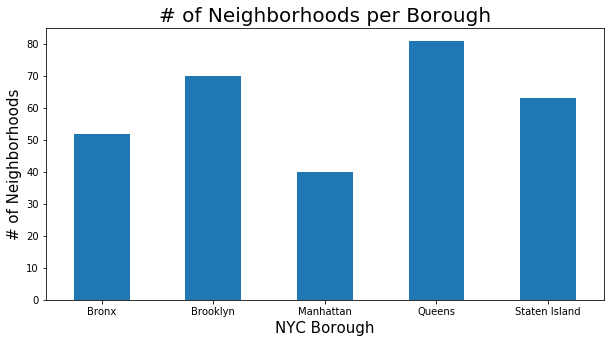

In [49]:
# Graph the number of neighborhoods per borough
neighborhoods.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5))
plt.title('# of Neighborhoods per Borough', fontsize=20)
plt.xlabel('NYC Borough', fontsize=15)
plt.ylabel('# of Neighborhoods', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

I define my Foursqaure credentials and make calls to generate venue data for each neighborhood.

In [29]:
# Define my Foursquare credentials
CLIENT_ID = 'AXQNKNPFRDAPGYCXWG0G2A0KPIPC53PUINBNCAMQSWXVNATM'
CLIENT_SECRET = 'W3SHTBPALY2JAZ3QW0F42SZUYQQWCZAC342WO34PK3RNEZHG'
VERSION = '20200622'

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

LIMIT = 100
radius = 500

My credentails:
CLIENT_ID: AXQNKNPFRDAPGYCXWG0G2A0KPIPC53PUINBNCAMQSWXVNATM
CLIENT_SECRET:W3SHTBPALY2JAZ3QW0F42SZUYQQWCZAC342WO34PK3RNEZHG


I define some functions that I will use to extract the venue types for the explore call for each neighborhood. The second function repeats the call for all of the neighborhoods in the dataframe.

In [28]:
# Create a function to extract the venue category type
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
# Create a function to explore nearby venues for all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I call the above function to generate a new dataframe containing the venues that were returned from each call to the Foursquare API for all of the neighborhoods.

In [33]:
# Call the function to get the venues for the neighborhoods in New York
NY_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                            latitudes=neighborhoods['Latitude'],
                            longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [34]:
# Check the size and first few rows of the resulting dataframe
print(NY_venues.shape)
NY_venues.head()

(10065, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


I explored the unique venue categories that were returned to come up with a list of the venues that would be prioritized for this specific analysis.

In [35]:
# Determine a list of the unique venue categories that were found
NY_venues['Venue Category'].unique()

array(['Dessert Shop', 'Pharmacy', 'Ice Cream Shop', 'Donut Shop',
       'Gas Station', 'Sandwich Place', 'Deli / Bodega', 'Laundromat',
       'Pizza Place', 'Discount Store', 'Post Office', 'Bagel Shop',
       'Grocery Store', 'Fast Food Restaurant', 'Restaurant',
       'Baseball Field', 'Fried Chicken Joint', 'Bus Station', 'Park',
       'Caribbean Restaurant', 'Diner', 'Seafood Restaurant',
       'Bowling Alley', 'Business Service', 'Automotive Shop',
       'Food & Drink Shop', 'Platform', 'Metro Station',
       'Convenience Store', 'Juice Bar', 'Chinese Restaurant', 'Plaza',
       'River', 'Bank', 'Home Service', 'Gym', 'Medical Supply Store',
       'Gourmet Shop', 'Latin American Restaurant', 'Pub', 'Burger Joint',
       'Beer Bar', 'Warehouse Store', 'Coffee Shop', 'Spanish Restaurant',
       'Mexican Restaurant', 'Bar', 'Wings Joint',
       'Thrift / Vintage Store', 'Trail', 'Supermarket', 'Bakery',
       'Candy Store', 'Café', 'Rental Car Location', 'Breakfast Spo

Once I had these venue categories, I created a new dataframe that was filtered to only include the venue types in the 'filters' list.

In [40]:
# Select the venue categories to filter by
filters = ['Pharmacy','Park','Playground','Kids Store','Baby Store','School','School','Daycare','Recreation Center']

# Create a new dataframe with only the venue categories that are of concern
NY_venuesFiltered = NY_venues[NY_venues['Venue Category'].isin(filters)].reset_index(drop=True)
NY_venuesFiltered.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Co-op City,40.874294,-73.829939,Rite Aid,40.870345,-73.828302,Pharmacy
3,Co-op City,40.874294,-73.829939,The Park,40.877645,-73.830836,Park
4,Riverdale,40.890834,-73.912585,Bell Tower Park,40.889178,-73.908331,Park


In [41]:
# Check the size of the dataframe
print('There were {} venues returned regarding family/child care in the New York neighborhoods.'.format(NY_venuesFiltered.shape[0]))

There were 464 venues returned regarding family/child care in the New York neighborhoods.


## Data Analysis

In order to make use of k-means clustering, I used one hot encoding to transform the data into a proper format for analysis.

In [42]:
# Use one hot encoding to analyze the dataframe
NY_onehot = pd.get_dummies(NY_venuesFiltered[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe in first column
NY_onehot['Neighborhood'] = NY_venuesFiltered['Neighborhood'] 
insert_Neigh = NY_onehot.pop('Neighborhood')
NY_onehot.insert(0, 'Neighborhood', insert_Neigh)

NY_onehot.head()

,Neighborhood,Baby Store,Daycare,Kids Store,Park,Pharmacy,Playground,Recreation Center,School
0,Wakefield,0,0,0,0,1,0,0,0
1,Wakefield,0,0,0,0,1,0,0,0
2,Co-op City,0,0,0,0,1,0,0,0
3,Co-op City,0,0,0,1,0,0,0,0
4,Riverdale,0,0,0,1,0,0,0,0


In [43]:
# Group rows by neighborhood and by taking the mean of the frequency of each category
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped.head()

,Neighborhood,Baby Store,Daycare,Kids Store,Park,Pharmacy,Playground,Recreation Center,School
0,Allerton,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Arrochar,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Arverne,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


I sorted the frequency of the category types to display the most frequent venue types first.

In [44]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
# Create a dataframe that displays the venues for each neighborhood in order of frequency
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
NY_venuesSorted = pd.DataFrame(columns=columns)
NY_venuesSorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    NY_venuesSorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

NY_venuesSorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Allerton,Playground,Pharmacy,School,Recreation Center,Park,Kids Store,Daycare,Baby Store
1,Annadale,Pharmacy,Park,School,Recreation Center,Playground,Kids Store,Daycare,Baby Store
2,Arden Heights,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store
3,Arrochar,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store
4,Arverne,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store


I used k-means clustering to group the neighborhoods based on the frequency of the filtered venue categories.

In [82]:
# Set the number of clusters for the neighborhoods
kclusters = 5

# Get the dataframe for clustering
NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# Check the cluster labels generated for each row
kmeans.labels_

array([4, 4, 0, 0, 2, 2, 0, 4, 1, 4, 4, 0, 2, 1, 1, 1, 0, 4, 2, 3, 4, 4,
       0, 2, 4, 3, 4, 0, 4, 0, 2, 3, 0, 1, 4, 1, 4, 4, 0, 3, 1, 1, 1, 3,
       2, 4, 2, 4, 0, 4, 4, 1, 2, 4, 4, 0, 0, 3, 3, 1, 4, 4, 1, 1, 1, 1,
       0, 4, 1, 0, 1, 4, 4, 4, 4, 3, 4, 2, 4, 3, 0, 4, 2, 3, 4, 0, 0, 3,
       3, 0, 0, 1, 1, 2, 0, 0, 1, 1, 3, 4, 4, 0, 3, 4, 2, 4, 4, 1, 0, 2,
       3, 4, 0, 4, 2, 3, 3, 0, 4, 1, 4, 0, 3, 4, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 3, 4, 0, 4, 0, 2, 4, 4, 4, 0, 1, 4, 0, 4, 3, 0, 2, 0, 4, 3,
       1, 1, 1, 4, 0, 1, 4, 1, 0, 0, 3, 0, 0, 0, 2, 0, 1, 4, 1, 1, 1, 1,
       4, 1, 0, 0, 3, 1, 0, 0, 1, 1, 1, 1, 3, 1, 1, 0, 3, 2, 2, 1, 0, 4,
       1, 0, 3, 1, 4, 3, 1, 4, 4, 3, 0, 0, 4], dtype=int32)

In [83]:
# Add clustering labels
NY_venuesSorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Merge the cluster labels and neighborhood data to add the latitude and longitude
NY_merged = NY_venuesSorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood', how='left')

# View the first few rows of the merged dataframe
NY_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
0,4,Allerton,Playground,Pharmacy,School,Recreation Center,Park,Kids Store,Daycare,Baby Store,Bronx,40.865788,-73.859319
1,4,Annadale,Pharmacy,Park,School,Recreation Center,Playground,Kids Store,Daycare,Baby Store,Staten Island,40.538114,-74.178549
2,0,Arden Heights,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Staten Island,40.549286,-74.185887
3,0,Arrochar,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Staten Island,40.596313,-74.067124
4,2,Arverne,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Queens,40.589144,-73.791992


Once the neighborhoods were clustered, I looked into what venue categories made up the clusters to determine general labels of what a neighborhood in that cluster was like.

In [89]:
# View the neighborhoods in the first cluster
NY_merged.loc[NY_merged['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
2,0,Arden Heights,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Staten Island,40.549286,-74.185887
3,0,Arrochar,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Staten Island,40.596313,-74.067124
6,0,Auburndale,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Queens,40.761730,-73.791762
11,0,Bayside,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Queens,40.766041,-73.774274
16,0,Belle Harbor,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Queens,40.576156,-73.854018
22,0,Borough Park,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Brooklyn,40.633131,-73.990498
27,0,Bulls Head,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Staten Island,40.609592,-74.159409
29,0,Cambria Heights,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Queens,40.692775,-73.735269
32,0,Castle Hill,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Bronx,40.819014,-73.848027
38,0,City Line,Pharmacy,School,Recreation Center,Playground,Park,Kids Store,Daycare,Baby Store,Brooklyn,40.678570,-73.867976


In [90]:
# View the neighborhoods in the second cluster
NY_merged.loc[NY_merged['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
8,1,Battery Park City,Park,Playground,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Manhattan,40.711932,-74.016869
13,1,Bedford Park,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Bronx,40.870185,-73.885512
14,1,Bedford Stuyvesant,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.687232,-73.941785
15,1,Beechhurst,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Queens,40.792781,-73.804365
33,1,Central Harlem,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Manhattan,40.815976,-73.943211
35,1,Chelsea,Park,Pharmacy,School,Recreation Center,Playground,Kids Store,Daycare,Baby Store,Manhattan,40.744035,-74.003116
35,1,Chelsea,Park,Pharmacy,School,Recreation Center,Playground,Kids Store,Daycare,Baby Store,Staten Island,40.594726,-74.189560
40,1,Claremont Village,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Bronx,40.831428,-73.901199
41,1,Clason Point,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Bronx,40.806551,-73.854144
42,1,Clifton,Park,School,Recreation Center,Playground,Pharmacy,Kids Store,Daycare,Baby Store,Staten Island,40.619178,-74.072642


In [92]:
# View the neighborhoods in the third cluster
NY_merged.loc[NY_merged['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
4,2,Arverne,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Queens,40.589144,-73.791992
5,2,Astoria Heights,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Queens,40.770317,-73.894680
12,2,Bayswater,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Queens,40.611322,-73.765968
18,2,Bensonhurst,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Brooklyn,40.611009,-73.995180
23,2,Briarwood,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Queens,40.710935,-73.811748
30,2,Carnegie Hill,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Manhattan,40.782683,-73.953256
44,2,Clinton Hill,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Brooklyn,40.693229,-73.967843
46,2,Cobble Hill,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.687920,-73.998561
52,2,Country Club,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Bronx,40.844246,-73.824099
77,2,Fox Hills,Playground,School,Recreation Center,Pharmacy,Park,Kids Store,Daycare,Baby Store,Staten Island,40.617311,-74.081740


In [93]:
# View the neighborhoods in the fourth cluster
NY_merged.loc[NY_merged['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
19,3,Bergen Beach,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.615150,-73.898556
25,3,Brooklyn Heights,Park,Pharmacy,Playground,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.695864,-73.993782
31,3,Carroll Gardens,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.680540,-73.994654
39,3,Civic Center,Park,Playground,Baby Store,School,Recreation Center,Pharmacy,Kids Store,Daycare,Manhattan,40.715229,-74.005415
43,3,Clinton,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Manhattan,40.759101,-73.996119
57,3,Downtown,Park,Kids Store,Baby Store,School,Recreation Center,Playground,Pharmacy,Daycare,Brooklyn,40.690844,-73.983463
58,3,Dumbo,Park,Playground,Pharmacy,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.703176,-73.988753
75,3,Fort Greene,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.688527,-73.972906
79,3,Fulton Ferry,Park,Playground,Pharmacy,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.703281,-73.995508
83,3,Gramercy,Playground,Park,Pharmacy,School,Recreation Center,Kids Store,Daycare,Baby Store,Manhattan,40.737210,-73.981376


In [94]:
# View the neighborhoods in the fifth cluster
NY_merged.loc[NY_merged['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
0,4,Allerton,Playground,Pharmacy,School,Recreation Center,Park,Kids Store,Daycare,Baby Store,Bronx,40.865788,-73.859319
1,4,Annadale,Pharmacy,Park,School,Recreation Center,Playground,Kids Store,Daycare,Baby Store,Staten Island,40.538114,-74.178549
7,4,Bath Beach,Pharmacy,Park,School,Recreation Center,Playground,Kids Store,Daycare,Baby Store,Brooklyn,40.599519,-73.998752
9,4,Bay Ridge,Playground,Pharmacy,Park,Kids Store,School,Recreation Center,Daycare,Baby Store,Brooklyn,40.625801,-74.030621
10,4,Bay Terrace,Kids Store,Pharmacy,School,Recreation Center,Playground,Park,Daycare,Baby Store,Queens,40.782843,-73.776802
10,4,Bay Terrace,Kids Store,Pharmacy,School,Recreation Center,Playground,Park,Daycare,Baby Store,Staten Island,40.553988,-74.139166
17,4,Belmont,Playground,Pharmacy,School,Recreation Center,Park,Kids Store,Daycare,Baby Store,Bronx,40.857277,-73.888452
20,4,Bloomfield,Recreation Center,School,Playground,Pharmacy,Park,Kids Store,Daycare,Baby Store,Staten Island,40.605779,-74.187256
21,4,Boerum Hill,Kids Store,School,Recreation Center,Playground,Pharmacy,Park,Daycare,Baby Store,Brooklyn,40.685683,-73.983748
24,4,Brighton Beach,Playground,Pharmacy,School,Recreation Center,Park,Kids Store,Daycare,Baby Store,Brooklyn,40.576825,-73.965094


### Determined Cluster Labels:
CLUSTER 0: Pharmacy <br>
CLUSTER 1: Park <br>
CLUSTER 2: Playground <br>
CLUSTER 3: Park & Playground <br>
CLUSTER 4: Pharmacy & Playground/Park <br>

## Results

Based on the data analysis, the neighborhoods in CLUSTER 3 had venue types including both parks and playgrounds. This was the determining factor in the conclusion that this cluster of neighborhoods would be the best for families in New York City. To display the final results, a map showing the locations of the neighborhoods was created and displayed. Additionally, the list of neighborhoods was generated again below.

In [96]:
# Create a dataframe that just includes the neighborhoods in cluster 3
NY_family = NY_merged.loc[NY_merged['Cluster Labels'] == 3]
NY_family.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
19,3,Bergen Beach,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.615150,-73.898556
25,3,Brooklyn Heights,Park,Pharmacy,Playground,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.695864,-73.993782
31,3,Carroll Gardens,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.680540,-73.994654
39,3,Civic Center,Park,Playground,Baby Store,School,Recreation Center,Pharmacy,Kids Store,Daycare,Manhattan,40.715229,-74.005415
43,3,Clinton,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Manhattan,40.759101,-73.996119


In [98]:
# Create a map of New York
map_family = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map for the neighborhoods in New York that are best for families
for lat, lng, label in zip(NY_family['Latitude'], NY_family['Longitude'], NY_family['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_family)  
    
map_family

In [99]:
# Display the final list of neighborhoods that are best for families in New York
NY_family

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Borough,Latitude,Longitude
19,3,Bergen Beach,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.615150,-73.898556
25,3,Brooklyn Heights,Park,Pharmacy,Playground,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.695864,-73.993782
31,3,Carroll Gardens,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.680540,-73.994654
39,3,Civic Center,Park,Playground,Baby Store,School,Recreation Center,Pharmacy,Kids Store,Daycare,Manhattan,40.715229,-74.005415
43,3,Clinton,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Manhattan,40.759101,-73.996119
57,3,Downtown,Park,Kids Store,Baby Store,School,Recreation Center,Playground,Pharmacy,Daycare,Brooklyn,40.690844,-73.983463
58,3,Dumbo,Park,Playground,Pharmacy,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.703176,-73.988753
75,3,Fort Greene,Playground,Park,School,Recreation Center,Pharmacy,Kids Store,Daycare,Baby Store,Brooklyn,40.688527,-73.972906
79,3,Fulton Ferry,Park,Playground,Pharmacy,School,Recreation Center,Kids Store,Daycare,Baby Store,Brooklyn,40.703281,-73.995508
83,3,Gramercy,Playground,Park,Pharmacy,School,Recreation Center,Kids Store,Daycare,Baby Store,Manhattan,40.737210,-73.981376
